# Probability and Statistics Report

## Introduction

At first, our team decided to investigate the academic performance of students in universities. We realized that our hypthesis was not well defined thus we changed it.
Write text balbabaa
<br>

## Code
Below is our code necessary to plot and compute the parameters for this study.
<br>You can skip to our *Hypothesis Testing section*.


In [1]:
import pandas as pd
import numpy as np
from numpy.polynomial.polynomial import polyfit

from matplotlib import pyplot as plt

import math
import csv
import scipy.stats as stats

Z_from_probability = stats.norm.ppf
probability_of_Z = stats.norm.cdf

# list respondents who gave fake answers or made mistakes in answering.
# They have to be removed from the analysis in order not to skew the results
blacklisted_emails = [
    'CleanYourData@Hal3anneh.com',
    'nope@hotmail.com',
    'eyePISSEDandFARDEDandSHIDDEDandCAMEallOVERthePLACE@lmao.pwned.com',
    'chadi.sargi@gmail.com'
]

original_survey = "./data/condensed.actual.latest.csv"
numerical_survey = './data/condensed.numerical.latest.csv'

#### Cleaning Data
This function cleans the data from the imported csv file. We used survey monkey to collect our data.

In [10]:
def clean(survey_filename: str):
    '''
    Remove the data points where people purpusefully tried to lie.
    Remove all metadata unrelated to business logic
    '''
    file = survey_filename
    numerical_raw_survey = pd.read_csv(file)
    total_rows = len(numerical_raw_survey.index)

    #print(total_rows)

    indexes_to_be_removed = []

    for i in range(1, total_rows):
        email_of_respondent = numerical_raw_survey.iloc[i, 17]
        gpa_of_respondent = float(numerical_raw_survey.iloc[i, 16])
        if email_of_respondent in blacklisted_emails or gpa_of_respondent <= 0.1:
            indexes_to_be_removed.append(i)

    numerical_raw_survey = numerical_raw_survey.drop(
        axis=0, index=indexes_to_be_removed)
    #print(len(numerical_raw_survey.index))

    # only keep answers to survey questions, exclude the faculty question
    # 17 is the index of the email column
    responses = numerical_raw_survey.iloc[1:, list(range(11, 17))]

    # cast string entries to float
    responses = pd.DataFrame.astype(responses, float)
    return responses


#### Statistics Functions
The functions below create the necessary objects to visualize the data.
<br>
Moreover, they are used to compute, the sample mean, variance standard deviation, standard error and the Z & p-values & Beta error.

In [3]:
def save_cleaned_dataframe(df):
    df.to_csv('./data/analysis.ready.data.csv', index=None, header=True)
    return


def plot_gpas_alone(data):
    questions = data.columns
    plt.plot(data[questions[5]], 'ro')
    plt.show()


def sample_size(data):
    return len(data.index)


def gpa_list(data):
    return list(data.iloc[:, 5])


def mean_gpa(data):
    gpas = gpa_list(data)
    sample_mean = sum(gpas)/len(gpas)
    return sample_mean


def sample_gpa_variance(data):
    # Extract gpas as numpy array to propagate math operations without looping
    # over each element.
    gpas = np.array(gpa_list(data))
    variance = (sum(gpas**2) - sum(gpas)**2/len(gpas)) / (len(gpas)-1)
    return variance


def std_dev_gpa(data):
    return math.sqrt(sample_gpa_variance(data))


def median_gpa(data):
    gpas = gpa_list(data)
    midpoint = int(len(gpas)/2)
    if len(gpas) % 2 == 0:
        return gpas[midpoint]
    lower = gpas[midpoint]
    upper = gpas[midpoint+1]
    median = (lower+upper)/2
    return median


def calculate_Z_value(mu0, X_bar, S, n):
    # because our sample size is greater than 200, we feel confident of
    # estimating sigma using S. In this way we can use the Z-distribution
    # instead of the T-distribution. This is often done when n > 30.
    Z = (X_bar - mu0)/(S/math.sqrt(n))
    return Z


def calculate_p_value(data, mu0=3.2):
    X_bar = mean_gpa(data)
    S = std_dev_gpa(data)
    n = sample_size(data)
    Z = abs(calculate_Z_value(mu0, X_bar, S, n))
    p_value = 2*probability_of_Z(-Z)
    return p_value, Z


def find_Z_alpha(confidence):
    alpha = 1-confidence
    Z_alpha_over2 = abs(Z_from_probability(1-alpha/2))
    return alpha, Z_alpha_over2


def beta_error(Zalpha2, sigma, n, mu0=3.2, mu1=3.3):
    old_Z = abs(Zalpha2)
    diff = mu1-mu0
    beta = probability_of_Z(old_Z-(diff*math.sqrt(n)/sigma))
    return beta

#### Normal Test
The functions below uses the following procedure to test sample data.
<br> 
\begin{align}
y = \frac{(j - 0.5)}{n} \\
X = x_{i}
\end{align}
Where $y$ represents the probabilites, $X$ data points and $j$ the integers from 1 to n.
<br>
Moreover, it will try to fit a best line to the data points.

In [26]:
def normal_plot(data):
    gpas = gpa_list(data)
    print(type("gpa type:",gpas))
    js = [j+1 for j in range(0, len(gpas))]
    prob_dis = [(j-0.5) / (len(js)) for j in js]
    plt.scatter(gpas, prob_dis, s=7, alpha=0.5)
    plt.show()
    plt.figure()

    b, m = polyfit(gpas, prob_dis, 1)
    plt.plot(gpas, prob_dis)
    plt.plot(gpas, b + m * gpas, '-')
    plt.show()

In [69]:
sr = pd.read_csv("data/Success Factors Study.csv")
sr.drop(sr.index[0], inplace=True)
sr['Finally, what is your gpa?'] = pd.to_numeric(sr['Finally, what is your gpa?'])
gpas = sr['Finally, what is your gpa?']
gpa_copy = gpas.sort_values()
gpa_copy = gpa_copy.drop_duplicates()
gpa_copy = gpa_copy.iloc[2:]

#### Cleaning the data and computing the statistics ;)

In [15]:
cleaned = clean(numerical_survey)
n = sample_size(cleaned)
xbar = mean_gpa(cleaned)
S_squared = sample_gpa_variance(cleaned)
S = std_dev_gpa(cleaned)

$\bar{x}$, $S^{2}$, $S$ and median are show below:

In [16]:
print("sample size:", n)
print("mean:", xbar)
print("variance:", S_squared)
print("standard dev:", S)
print("median:", median_gpa(cleaned))


sample size: 206
mean: 3.289330097087381
variance: 0.2687755002604673
standard dev: 0.5184356278849548
median: 3.4


## Hypothesis Testing
### Step 1-3
For this study, the $\mu$ of the gpas collected is our parameter of interest and we settled on two sides hypothetis.
<br> <br>
$H_{0}$: $\mu = 3.2$ 
<br>
$H_{1}$: $\mu \neq 3.2$
<br>


### Normal Testing Our Data
Before proceding to step 4 of our testing, lets perform the normal test mentioned previously.

Text(0.5,1,'Normal Test')

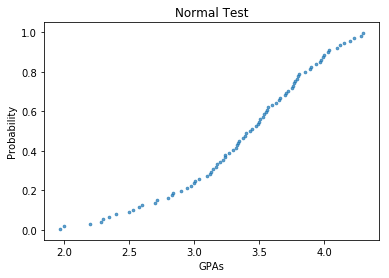

In [78]:
js = [j+1 for j in range(0, len(gpa_copy))]
prob_dis = [(j-0.5) / (len(js)) for j in js]

plt.scatter(gpa_copy, prob_dis, s=7, alpha=0.7)
plt.xlabel('GPAs')
plt.ylabel('Probability')
plt.title('Normal Test')

Text(0.5,1,'Best Fit Line')

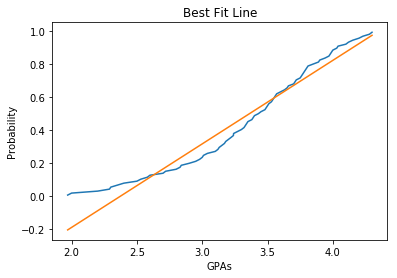

In [77]:
b, m = polyfit(gpa_copy, prob_dis, 1)
plt.plot(gpa_copy, prob_dis)
plt.plot(gpa_copy, b + m * gpa_copy, '-')
plt.xlabel('GPAs')
plt.ylabel('Probability')
plt.title('Best Fit Line')

Thus, blabalba normal distribution.

### Step 4 
Our sample size is $n = 211$.
<br>
Therefore we can use the Z-distribution since the sample size is large enough. 
<br>
$Z_{ \alpha / 2}= \frac{\mu - \bar{x}}{s / \sqrt{n}}$

### Step 5
Our sample size is large enough, thus we decided to use $\alpha = 0.02$ for our confidence level.
<br>
Our resulting critical values $\pm Z_{ \alpha / 2} $ are:

In [14]:
alpha, cutoff_Z = find_Z_alpha(0.98)
print("alpha:", alpha)
print("Z alpha/2:", cutoff_Z)

alpha: 0.020000000000000018
Z alpha/2: 2.3263478740408408


Thus, if our test statistic $Z_{0} < -2.33$ or $Z_{0} > 2.33$, we will reject our null hypthesis.

### Step 6
Now, we compute our test statistic $Z_{0}$:

In [18]:
mu0=3.2
p_value, actual_Z = calculate_p_value(cleaned, mu0=mu0)
print("actual Z:", actual_Z)

actual Z: 2.473070954112705


### Step 7
Lets compute the p-value before drawing our conclusion.

In [19]:
print("p_value:", p_value)

p_value: 0.013395754395141526


$p < \alpha$, thus we have enough evidence to our reject our null hypothesis <br>
$H_{0}$: $\mu_{0} = 3.2$

### Analysing Type I & II Error
We saw that our type I error was $0.02$ or $2 \%$ of rejecting our $H_{0}$ when it is true. 
<br>
Now, we will compute our type II error assuming the true $\mu = 3.3$.
<br>
Following the formula for $\beta$
\begin{align}
\beta = \phi[Z_{ \alpha / 2} - \frac{\delta\sqrt(n)}{s}] - \phi[-Z_{ \alpha / 2} - \frac{\delta\sqrt(n)}{s}]
\end{align}
Gives us:

In [20]:
beta = beta_error(cutoff_Z, S, n)
print("beta error:", beta)
print("power of test:", 1-beta)

beta error: 0.32920284095428376
power of test: 0.6707971590457162


We see that we have $33\%$ of accepting our $H_{0}$ when it is false. 
<br>
Thus, we do not have enough evidence to reject $H_{1}: \mu \neq 3.2$